In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from statsmodels.tsa.stattools import kpss
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading demand dataset

In [3]:
DEMAND_DIR = 'drive/MyDrive/final_demand.parquet'
CLEAN_DATA_DIR = 'drive/MyDrive/CleanDatasetPackage/clean_data.parquet'

In [4]:
df_10m = pd.read_parquet(DEMAND_DIR)

### plot demand of 10 pulocationid based on time

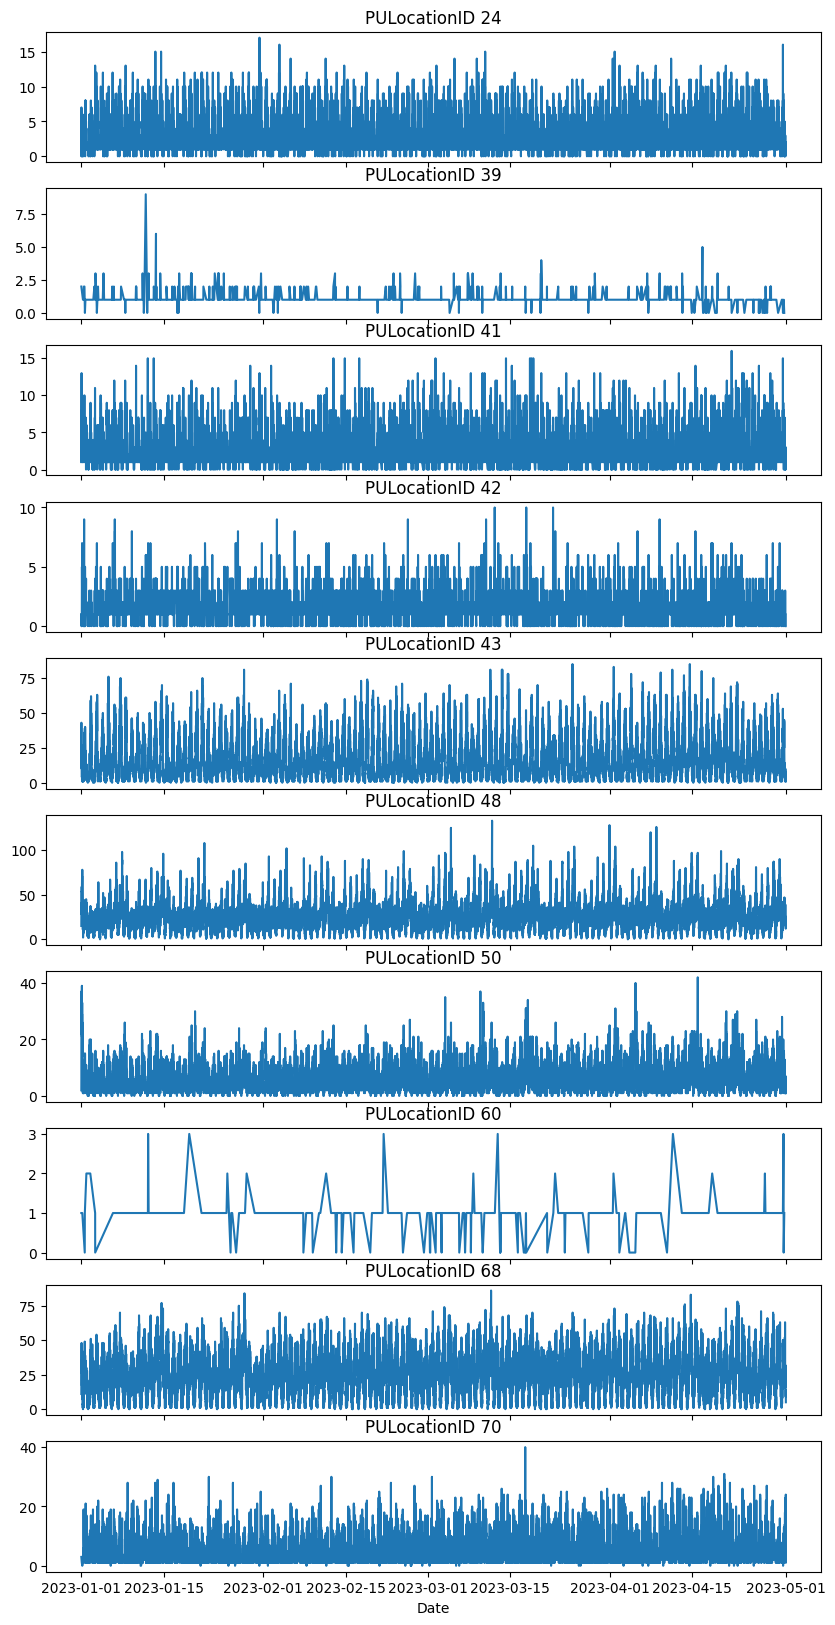

In [5]:
pulocationid_list = df_10m['PULocationID'].unique()[:10]

fig, axs = plt.subplots(len(pulocationid_list), 1, figsize=(10, 20), sharex=True)

for i, pulocationid in enumerate(pulocationid_list):
    pulocationid_data = df_10m[df_10m['PULocationID'] == pulocationid]
    axs[i].plot(pulocationid_data["timestamp"], pulocationid_data['demand'])
    axs[i].set_title(f'PULocationID {pulocationid}')

axs[-1].set_xlabel('Date')

plt.show()

### Add Borough

In [6]:
zones_df = pd.read_csv('drive/MyDrive/CleanDatasetPackage/zones.csv')
pulocationid_to_borough = dict(zip(zones_df.LocationID, zones_df.Borough))

df_10m['Borough'] = df_10m['PULocationID'].map(pulocationid_to_borough)
######### uncomment this if you want to only model data for a specific borough.#############
# df_10m = df_10m.query("Borough == 'Brooklyn'")

### Add weather

In [7]:
manhattan = pd.read_csv('drive/MyDrive/rahnema-demand/manhattan.csv')
queens = pd.read_csv('drive/MyDrive/rahnema-demand/queens.csv')
bronx = pd.read_csv('drive/MyDrive/rahnema-demand/bronx.csv')
island = pd.read_csv('drive/MyDrive/rahnema-demand/staten island.csv')
brooklyn = pd.read_csv('drive/MyDrive/rahnema-demand/brooklyn.csv')
ewr = pd.read_csv('drive/MyDrive/rahnema-demand/EWR.csv')

weather = pd.concat([manhattan, queens, bronx, island, brooklyn, ewr], axis=0)
weather.rename(columns={"name":"Borough", "datetime":"date"}, inplace=True)
weather["date"] = pd.to_datetime(weather["date"])
weather

,Borough,date,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Manhattan,2023-01-01,12.2,10.0,11.1,12.2,8.5,11.0,4.3,64.9,...,8.4,4,10,2023-01-01T07:20:11,2023-01-01T16:39:10,0.32,"Rain, Partially cloudy",Becoming cloudy in the afternoon with early mo...,rain,"72505394728,KLGA,F8726,KNYC,F1417,72503014732"
1,Manhattan,2023-01-02,13.3,8.4,11.3,13.3,7.1,11.0,4.2,62.3,...,3.6,3,10,2023-01-02T07:20:17,2023-01-02T16:40:01,0.35,"Rain, Partially cloudy",Becoming cloudy in the afternoon with late aft...,rain,"72505394728,KLGA,F8726,KNYC,F1417,72503014732"
2,Manhattan,2023-01-03,13.0,7.9,10.6,13.0,6.6,10.3,8.7,87.9,...,1.5,1,10,2023-01-03T07:20:21,2023-01-03T16:40:53,0.39,"Rain, Overcast",Cloudy skies throughout the day with rain in t...,rain,"72505394728,KLGA,KNYC,F1417,72503014732"
3,Manhattan,2023-01-04,18.7,9.2,14.4,18.7,7.3,14.2,10.8,79.7,...,5.1,3,10,2023-01-04T07:20:22,2023-01-04T16:41:47,0.42,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"72505394728,KLGA,F8726,KNYC,F1417,72503014732"
4,Manhattan,2023-01-05,9.4,7.1,8.5,8.8,4.3,7.0,7.1,90.7,...,2.3,1,10,2023-01-05T07:20:21,2023-01-05T16:42:43,0.46,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72505394728,KLGA,F8726,KNYC,F1417,72503014732"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,union country,2023-04-26,12.3,-2.5,5.3,12.3,-3.3,4.6,-2.5,61.0,...,17.8,7,10,2023-04-26T05:56:53,2023-04-26T19:47:55,0.21,Clear,Clear conditions throughout the day.,clear-day,"72530594892,72543094822,KRFD,E6185,KDPA"
116,union country,2023-04-27,19.1,0.7,10.4,19.1,-0.8,9.9,-1.1,49.3,...,19.9,7,10,2023-04-27T05:55:27,2023-04-27T19:49:02,0.25,Clear,Clear conditions throughout the day.,clear-day,"72530594892,72543094822,KRFD,E6185,KDPA"
117,union country,2023-04-28,18.9,4.5,12.4,18.9,2.8,12.1,0.3,47.0,...,16.6,6,10,2023-04-28T05:54:02,2023-04-28T19:50:09,0.27,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72530594892,72543094822,KRFD,E6185,KDPA"
118,union country,2023-04-29,13.4,5.9,9.2,13.4,4.4,8.4,2.6,64.1,...,6.7,6,10,2023-04-29T05:52:38,2023-04-29T19:51:16,0.31,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"72530594892,72543094822,KRFD,E6185,KDPA"


In [8]:
weather.loc[weather['Borough'] == "NewYork, queens ", 'Borough'] = "Queens"
weather.loc[weather['Borough'] == "NewYork, bronx", 'Borough'] = "Bronx"
weather.loc[weather['Borough'] == "NewYork, staten island ", 'Borough'] = "Staten Island"
weather.loc[weather['Borough'] == "NewYork, Brooklyn ", 'Borough'] = "Brooklyn"
weather.loc[weather['Borough'] == "union country", 'Borough'] = "EWR"

weather = weather[["Borough", "date", "tempmax", "tempmin", "icon"]]
weather

,Borough,date,tempmax,tempmin,icon
0,Manhattan,2023-01-01,12.2,10.0,rain
1,Manhattan,2023-01-02,13.3,8.4,rain
2,Manhattan,2023-01-03,13.0,7.9,rain
3,Manhattan,2023-01-04,18.7,9.2,rain
4,Manhattan,2023-01-05,9.4,7.1,rain
...,...,...,...,...,...
115,EWR,2023-04-26,12.3,-2.5,clear-day
116,EWR,2023-04-27,19.1,0.7,clear-day
117,EWR,2023-04-28,18.9,4.5,partly-cloudy-day
118,EWR,2023-04-29,13.4,5.9,rain


In [9]:
df_10m["date"] = df_10m["timestamp"].dt.date
df_10m['date'] = pd.to_datetime(df_10m['date'])

df_10m = pd.merge(df_10m, weather, on=['Borough',"date"], how="left")
df_10m.drop("date", axis=1, inplace=True)
df_10m = df_10m.set_index("timestamp")
df_10m = df_10m.sort_index()

### Filling null values of weather

In [10]:
df_10m.fillna(method='ffill', inplace=True)

### Label encoding of borough and icon

In [11]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Fit the label encoder to the categorical column
df_10m['Borough'] = le.fit_transform(df_10m['Borough'])
df_10m['icon'] = le.fit_transform(df_10m['icon'])


In [12]:
df_10m

,PULocationID,demand,Borough,tempmax,tempmin,icon
timestamp,,,,,,
2023-01-01 00:00:00,24,1.0,3,12.2,10.0,3
2023-01-01 00:00:00,39,2.0,1,12.2,10.0,3
2023-01-01 00:00:00,41,1.0,3,12.2,10.0,3
2023-01-01 00:00:00,42,1.0,3,12.2,10.0,3
2023-01-01 00:00:00,43,15.0,3,12.2,10.0,3
...,...,...,...,...,...,...
2023-04-30 23:50:00,239,5.0,3,15.9,10.0,3
2023-04-30 23:50:00,246,3.0,3,15.9,10.0,3
2023-04-30 23:50:00,249,12.0,3,15.9,10.0,3


### Feature Extraction for timestamp

In [13]:
df_10m.reset_index(inplace=True)
df_10m["seconds"] = df_10m["timestamp"].map(pd.Timestamp.timestamp)

In [14]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

seconds_in_day = 24 * 60 * 60
seconds_in_week = 7 * seconds_in_day

df_10m["time_sin"] = sin_transformer(seconds_in_day).fit_transform(df_10m["seconds"])
df_10m["time_cos"] = cos_transformer(seconds_in_day).fit_transform(df_10m["seconds"])

df_10m["week_sin"] = sin_transformer(seconds_in_week).fit_transform(df_10m["seconds"])
df_10m["week_cos"] = cos_transformer(seconds_in_week).fit_transform(df_10m["seconds"])

df_10m.drop('seconds' , axis=1, inplace=True)
df_10m.set_index("timestamp", inplace=True)
df_10m

,PULocationID,demand,Borough,tempmax,tempmin,icon,time_sin,time_cos,week_sin,week_cos
timestamp,,,,,,,,,,
2023-01-01 00:00:00,24,1.0,3,12.2,10.0,3,-1.129255e-11,1.000000,0.433884,-0.900969
2023-01-01 00:00:00,39,2.0,1,12.2,10.0,3,-1.129255e-11,1.000000,0.433884,-0.900969
2023-01-01 00:00:00,41,1.0,3,12.2,10.0,3,-1.129255e-11,1.000000,0.433884,-0.900969
2023-01-01 00:00:00,42,1.0,3,12.2,10.0,3,-1.129255e-11,1.000000,0.433884,-0.900969
2023-01-01 00:00:00,43,15.0,3,12.2,10.0,3,-1.129255e-11,1.000000,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...
2023-04-30 23:50:00,239,5.0,3,15.9,10.0,3,-4.361939e-02,0.999048,-0.428259,-0.903656
2023-04-30 23:50:00,246,3.0,3,15.9,10.0,3,-4.361939e-02,0.999048,-0.428259,-0.903656
2023-04-30 23:50:00,249,12.0,3,15.9,10.0,3,-4.361939e-02,0.999048,-0.428259,-0.903656


### Add holiday

In [15]:
df_10m = df_10m.reset_index()

In [16]:
holidays = pd.to_datetime(["2023-1-2","2023-1-16", "2023-2-20", "2023-5-29","2023-7-4", "2023-9-4", "2023-10-9", "2023-11-10", "2023-11-23","2023-12-25"])

def is_holiday(date):
    return (date in holidays)

df_10m['holiday'] = np.where((df_10m["timestamp"].dt.dayofweek >= 5) | (df_10m["timestamp"].dt.date.apply(is_holiday)), 1, 0)
df_10m = df_10m.set_index("timestamp")

### Adding window feature for demand

In [17]:
def add_window_feature(df, col, window):
  grouped_df = df.groupby('PULocationID')

  # calculate the rolling mean and standard deviation using a window of 8 for each group
  rolling_mean = grouped_df[col].rolling(window=window).mean().reset_index()
  rolling_std = grouped_df[col].rolling(window=window).std().reset_index()

  # rename the columns of the resulting dataframes
  rolling_mean.columns = ['PULocationID', 'timestamp', 'rollingMean']
  rolling_std.columns = ['PULocationID', 'timestamp', 'rollingStd']
  rolling_mean["timestamp"] = pd.to_datetime(rolling_mean["timestamp"])
  rolling_std["timestamp"] = pd.to_datetime(rolling_std["timestamp"])

  df = df.reset_index()

  df = pd.merge(df, rolling_mean, on=['timestamp', 'PULocationID'], how='left')
  df = pd.merge(df, rolling_std, on=['timestamp', 'PULocationID'], how='left')
  return df

df_10m = add_window_feature(df_10m, "demand", 5)
df_10m = df_10m.fillna(0)
df_10m = df_10m.set_index("timestamp")

In [18]:
df_10m

,PULocationID,demand,Borough,tempmax,tempmin,icon,time_sin,time_cos,week_sin,week_cos,holiday,rollingMean,rollingStd
timestamp,,,,,,,,,,,,,
2023-01-01 00:00:00,24,1.0,3,12.2,10.0,3,-1.129255e-11,1.000000,0.433884,-0.900969,1,0.0,0.000000
2023-01-01 00:00:00,39,2.0,1,12.2,10.0,3,-1.129255e-11,1.000000,0.433884,-0.900969,1,0.0,0.000000
2023-01-01 00:00:00,41,1.0,3,12.2,10.0,3,-1.129255e-11,1.000000,0.433884,-0.900969,1,0.0,0.000000
2023-01-01 00:00:00,42,1.0,3,12.2,10.0,3,-1.129255e-11,1.000000,0.433884,-0.900969,1,0.0,0.000000
2023-01-01 00:00:00,43,15.0,3,12.2,10.0,3,-1.129255e-11,1.000000,0.433884,-0.900969,1,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 23:50:00,239,5.0,3,15.9,10.0,3,-4.361939e-02,0.999048,-0.428259,-0.903656,1,4.8,3.346640
2023-04-30 23:50:00,246,3.0,3,15.9,10.0,3,-4.361939e-02,0.999048,-0.428259,-0.903656,1,5.4,2.701851
2023-04-30 23:50:00,249,12.0,3,15.9,10.0,3,-4.361939e-02,0.999048,-0.428259,-0.903656,1,13.4,3.361547


### Add lag for demand

In [19]:
# 10-min lagging
number_of_lags = 5
grouped = df_10m.groupby("PULocationID")
for i in range(1, number_of_lags + 1):
  df_10m['demand_lagged'+str(i)] = grouped["demand"].shift(i)

# fill nan lags
grouped = df_10m.groupby("PULocationID")
for i in range(1, number_of_lags + 1):
  df_10m['demand_lagged'+str(i)] = grouped['demand_lagged'+str(i)].fillna(method="bfill")


### Splitting data

In [20]:
split_date = '2023-4-1 00:00:00'
data_train = df_10m.loc[df_10m.index < split_date].copy()
data_test = df_10m.loc[df_10m.index >= split_date].copy()
print(data_train.shape, data_test.shape)

(782990, 18) (268128, 18)


### target encoding for PULocationID

In [21]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    return df[by].map(smooth)

In [22]:
data_train["PULocationID"] = calc_smooth_mean(data_train, 'PULocationID', 'demand', 1)
data_test["PULocationID"] = calc_smooth_mean(data_test, 'PULocationID', 'demand', 1)

In [23]:
data_train.head(20)

,PULocationID,demand,Borough,tempmax,tempmin,icon,time_sin,time_cos,week_sin,week_cos,holiday,rollingMean,rollingStd,demand_lagged1,demand_lagged2,demand_lagged3,demand_lagged4,demand_lagged5
timestamp,,,,,,,,,,,,,,,,,,
2023-01-01,3.261240,1.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2023-01-01,1.157180,2.0,1,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,2.0,2.0,2.0,2.0,2.0
2023-01-01,2.861338,1.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2023-01-01,1.603504,1.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2023-01-01,18.578074,15.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,15.0,15.0,15.0,15.0,15.0
2023-01-01,25.507193,15.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,15.0,15.0,15.0,15.0,15.0
2023-01-01,6.143428,2.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,2.0,2.0,2.0,2.0,2.0
2023-01-01,0.988774,1.0,0,11.9,9.7,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2023-01-01,24.056465,11.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,11.0,11.0,11.0,11.0,11.0


### Train xgboost model

In [25]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
X_train = data_train.drop(["demand"], axis=1)
y_train = data_train["demand"]

X_test = data_test.drop(["demand"], axis=1)
y_test = data_test["demand"]

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

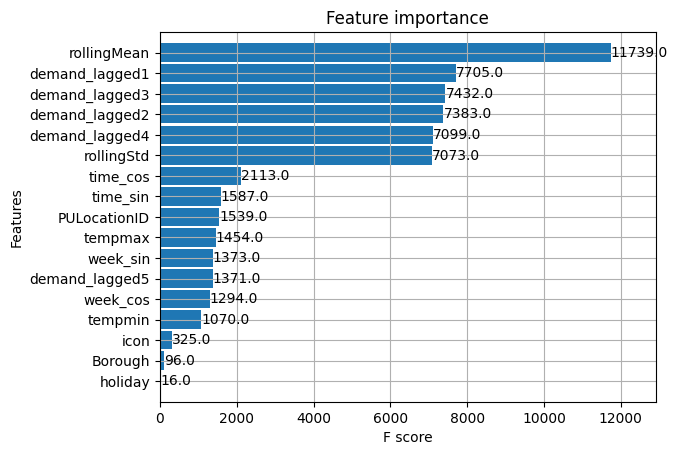

In [26]:
plot_importance(reg, height=0.9)

In [27]:
def evaluate():
  print("r2-score: ",r2_score(y_test, data_test["demand_prediction"]))
  print("MSE: ", mean_squared_error(y_test, data_test["demand_prediction"]))
  print("MAPE: ", mean_absolute_percentage_error(y_test, data_test["demand_prediction"]))
  print("MAE: ",mean_absolute_error(y_test, data_test["demand_prediction"]))

<Axes: xlabel='timestamp'>

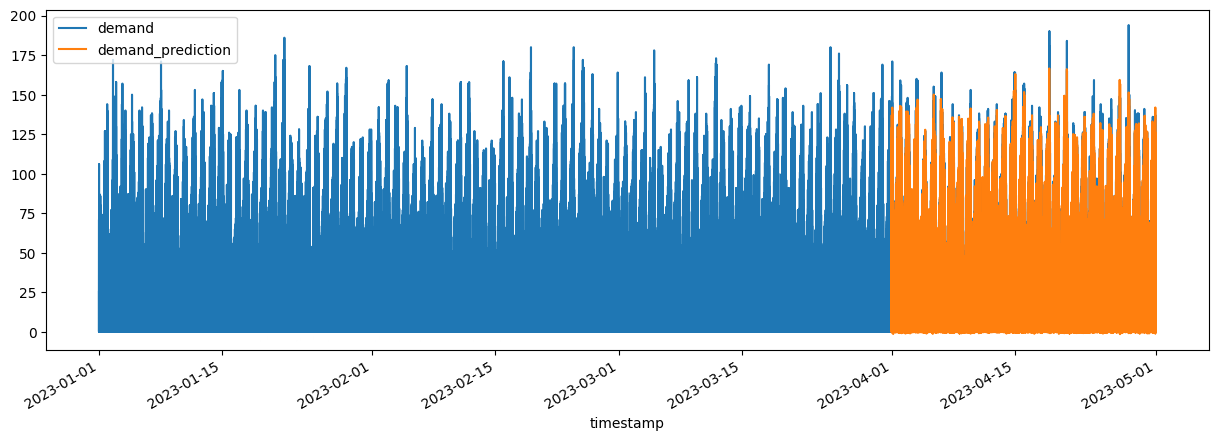

In [28]:
data_test['demand_prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

data_all[['demand','demand_prediction']].plot(figsize=(15, 5))

In [29]:
evaluate()

r2-score:  0.9979760059002187
MSE:  0.7960225560408888
MAPE:  12895147181284.695
MAE:  0.40479939068915294


In [30]:
df_10m.head()

,PULocationID,demand,Borough,tempmax,tempmin,icon,time_sin,time_cos,week_sin,week_cos,holiday,rollingMean,rollingStd,demand_lagged1,demand_lagged2,demand_lagged3,demand_lagged4,demand_lagged5
timestamp,,,,,,,,,,,,,,,,,,
2023-01-01,24,1.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2023-01-01,39,2.0,1,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,2.0,2.0,2.0,2.0,2.0
2023-01-01,41,1.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2023-01-01,42,1.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2023-01-01,43,15.0,3,12.2,10.0,3,-1.129255e-11,1.0,0.433884,-0.900969,1,0.0,0.0,15.0,15.0,15.0,15.0,15.0


### Load main dataset and clean it

In [31]:
df = pd.read_parquet(CLEAN_DATA_DIR)
df["store_and_fwd_flag"] = df["store_and_fwd_flag"].replace({'N': 0, 'Y': 1})
df.trip_distance.fillna(0, inplace=True)
df = df.query("tpep_pickup_datetime.dt.month <= 4")

In [32]:
df

,tpep_pickup_datetime,VendorID,tpep_dropoff_datetime,passenger_count,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration,trip_distance,Duration_total_Seconds
0,2023-01-01 00:00:00,2,2023-01-01 00:08:00,0.0,1.0,0,42,41,0,12.98,...,0.5,0.00,0.00,1.0,14.48,0.0,0.00,480.0,1.53,480.0
1,2023-01-01 00:00:05,2,2023-01-01 00:26:27,1.0,1.0,0,249,186,2,21.90,...,0.5,0.00,0.00,1.0,26.90,2.5,0.00,1582.0,1.32,1582.0
2,2023-01-01 00:00:06,2,2023-01-01 00:05:44,1.0,1.0,0,125,68,2,9.30,...,0.5,0.00,0.00,1.0,14.30,2.5,0.00,338.0,1.70,338.0
3,2023-01-01 00:00:08,2,2023-01-01 00:11:24,1.0,1.0,0,42,244,2,16.30,...,0.5,0.00,0.00,1.0,18.80,0.0,0.00,676.0,3.10,676.0
4,2023-01-01 00:00:09,2,2023-01-01 00:15:10,1.0,1.0,0,79,231,1,19.80,...,0.5,7.44,0.00,1.0,32.24,2.5,0.00,901.0,3.80,901.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12672566,2023-04-30 23:59:53,1,2023-05-01 00:13:29,1.0,1.0,0,164,262,1,17.00,...,0.5,4.40,0.00,1.0,26.40,2.5,0.00,816.0,3.40,816.0
12672567,2023-04-30 23:59:54,2,2023-05-01 00:16:51,1.0,1.0,0,138,65,1,38.00,...,0.5,13.65,0.00,1.0,60.90,0.0,1.75,1017.0,9.72,1017.0
12672568,2023-04-30 23:59:55,2,2023-05-01 01:02:30,1.0,2.0,0,132,262,1,70.00,...,0.5,14.00,6.55,1.0,96.30,2.5,1.75,3755.0,21.87,3755.0
12672569,2023-04-30 23:59:55,1,2023-05-01 00:05:21,1.0,1.0,0,137,141,1,10.70,...,0.5,3.10,0.00,1.0,18.80,2.5,0.00,326.0,2.20,326.0


### Calculate VIF
In statistics, the variance inflation factor (VIF) is the ratio (quotient) of the variance of estimating some parameter in a model that includes multiple other terms (parameters) by the variance of a model constructed using only one term.[1] It quantifies the severity of multicollinearity in an ordinary least squares regression analysis.

In [33]:
def get_VIF(df):
  vif_data = pd.DataFrame()
  vif_data["feature"] = df.columns

  vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                            for i in range(len(df.columns))]
  vif_data.sort_values("VIF", ascending=False, inplace=True)
  return vif_data

In [34]:
# to calculate VIF, datetime columns shall be deleted
df_temp = df.drop("tpep_dropoff_datetime", axis=1)
df_temp = df_temp.drop("tpep_pickup_datetime", axis=1)

In [35]:
get_VIF(df_temp)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
18,Duration_total_Seconds,inf
16,duration,inf
12,improvement_surcharge,151.538144
9,mta_tax,136.475290
13,total_amount,57.874952
7,fare_amount,25.488893
0,VendorID,21.673205
14,congestion_surcharge,14.026532
17,trip_distance,13.810096
4,PULocationID,7.484423


In [36]:
df_temp = df_temp.drop(["Duration_total_Seconds", "duration", "improvement_surcharge", "mta_tax", "fare_amount", "VendorID", "congestion_surcharge", "total_amount"], axis=1)

from VIF, it is obvious that we should delete all columns related to money. we deleted total_amount too because it had correlation with trip_distance. Also we should delete VendorID column(high VIF).
we deleted duration and total_seconds.

### Write agg function for dataset
we won't use columns which we deleted based on VIF. Also we won't include passenger_couunt in aggregated dataset. because number of passengers for each pulocationid and each timestamp is the definition of demand.

In [37]:
df = df.set_index("tpep_pickup_datetime")
df_agg = df.groupby([pd.Grouper(freq="10T"), "PULocationID"]).agg({
    "trip_distance": "mean",
    "RatecodeID": lambda x: x.mode()[0],
    "store_and_fwd_flag": lambda x: x.mode()[0],
    "payment_type": lambda x: x.mode()[0],
})
df_agg

trip_distance  RatecodeID  \
tpep_pickup_datetime PULocationID                              
2023-01-01 00:00:00  24                 1.400000         1.0   
                     39                 9.750000         1.0   
                     41                 1.200000         1.0   
                     42                 2.315000         1.0   
                     43                 2.062500         1.0   
...                                          ...         ...   
2023-04-30 23:50:00  239                1.764000         1.0   
                     246                1.572500         1.0   
                     249                3.304444         1.0   
                     262                0.570000         1.0   
                     263                5.298333         1.0   

                                   store_and_fwd_flag  payment_type  
tpep_pickup_datetime PULocationID                                    
2023-01-01 00:00:00  24                             0             2  
                     39                             0             2  
                     41                             0             4  
                     42                             0             0  
                     43                             0             1  
...                                               ...           ...  
2023-04-30 23:50:00  239                            0             1  
                     246                            0             1  
                     249                            0             1  
                     262                            0             1  
                     263                            0             1  

[1051118 rows x 4 columns]

### Merge demand with aggregated dataset(df_agg)

In [ ]:
df_agg = df_agg.reset_index()
df_agg = df_agg.rename(columns={"tpep_pickup_datetime":"timestamp"})
df_10m = df_10m.reset_index()
df_merged = pd.merge(df_agg, df_10m, on=['timestamp', 'PULocationID'], how='left')
df_merged = df_merged.set_index("timestamp")

In [39]:
get_VIF(df_merged.fillna(0))

,feature,VIF
15,rollingMean,6365.065187
19,demand_lagged3,284.184409
18,demand_lagged2,283.467538
20,demand_lagged4,283.390871
17,demand_lagged1,281.853617
5,demand,277.951517
7,tempmax,14.876587
21,demand_lagged5,13.819210
6,Borough,12.155126
8,tempmin,6.441132


payment_type seems to have high VIF. So we will drop it

In [40]:
df_merged = df_merged.drop(["payment_type"], axis=1)
df_merged = df_merged.fillna(0)

### Feature Importance

In [41]:
split_date = '2023-04-01 00:00:00'
data_train = df_merged.loc[df_merged.index < split_date].copy()
data_test = df_merged.loc[df_merged.index >= split_date].copy()
print(data_train.shape, data_test.shape)

(782990, 21) (268128, 21)


In [42]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
X_train = data_train.drop(["demand"], axis=1)
y_train = data_train["demand"]

X_test = data_test.drop(["demand"], axis=1)
y_test = data_test["demand"]

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

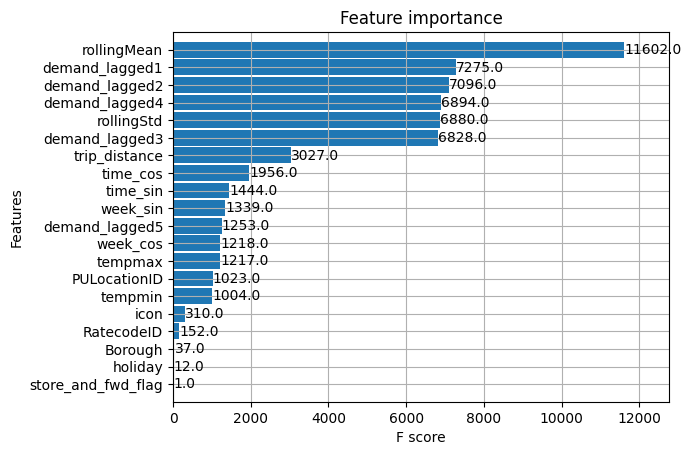

In [43]:
plot_importance(reg, height=0.9)